In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.3 MB/s eta 0:00:00


In [3]:
import torch
from torch import nn, tensor, Tensor
from tqdm.notebook import tqdm 
from torch.utils.data import DataLoader
import h5py
import numpy as np
from typing import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import pytorch_lightning as pl
from torch.optim.lr_scheduler import *
import pickle

In [4]:
!pip install pythreshold

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pythreshold: filename=pythreshold-0.3.1-py3-none-any.whl size=25035 sha256=3f64d12ce6717de2151cfd8672a22e73fc80fefca1d50466718d748cc46b0c2a
  Stored in directory: /root/.cache/pip/wheels/c8/f2/0d/66117bc7a8742329e756cde86fe0deb45ddc9b8bc83b26f187
Successfully built pythreshold


In [16]:
"""
Функционал, используемый для обработки изображения.

Функции view_image, view_images являются отладочными или используются для демонстрации работы алгоритмов.

Класс PicHandler используется для перевода изображение в полутоновое представление (в градациях серого),
для его фильтрации, бинаризации (алгоритмы  адаптивной бинаризации), обрезки и т.д.
"""


from __future__ import annotations
from typing import *
import cv2
import numpy as np
from pythreshold.utils import *
#from utils.geometry import Rect
from skimage.transform import resize, rescale
import enum


class FilterType(enum.Enum):
    GAUSSIAN_FILTER = 0
    MEDIAN_FILTER = 1

class StackingType(enum.Enum):
    HORIZONTAL = 0
    VERTICAL = 1


class Side(enum.Enum):
    left = 'left'
    right = 'right'
    top = 'top'
    bottom = 'bottom'
    all = 'all'


def view_image(image: np.ndarray, name_of_window: str = 'Image'):
    # выводит на экран изображение image (массив представления BGR)
    cv2.namedWindow(name_of_window, cv2.WINDOW_FULLSCREEN)
    cv2.imshow(name_of_window, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def view_images(images: Iterable[np.ndarray], name_of_window: str = 'Images', 
                stacking: StackingType = StackingType.HORIZONTAL):
    # выводит на экран набор изображений images (массивы представлений BGR)
    cv2.namedWindow(name_of_window, cv2.WINDOW_NORMAL)
    res = images[0]
    if stacking == StackingType.HORIZONTAL:
        ax = 1
    else:
        ax = 0
    for i in range(1, len(images)):
        res = np.concatenate((res, images[i]), axis=ax)

    cv2.imshow(name_of_window, res)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


class PicHandler:
    img: np.ndarray  # объект изображения в BGR

    def __init__(self, image: Union[str, np.ndarray], make_copy: bool = True, is_colored: bool = True):
        # image -- путь к файлу с изображением или np.ndarray -- представление изображения BGR в виде массива;
        # если передан массив, то make_copy: bool -- необходимо ли работать с копией переданного массива;
        # если передан путь к файлу, то изображение открывается, и при is_colored = True делается черно-белым

        if isinstance(image, np.ndarray):
            if make_copy:
                self.img = image.copy()
            else:
                self.img = image
            if is_colored:
                self.img = self.make_black_and_white(self.img)

        elif isinstance(image, type('')):
            t = cv2.imread(image)

            if isinstance(t, type(None)):
                # изображение не удалось загрузить
                raise Exception("Некорректный путь к изображению")

            if is_colored:
                t = self.make_black_and_white(t)

            self.img = t

    def get_image(self) -> np.ndarray:
        return self.img

    @staticmethod
    def make_black_and_white(img: np.ndarray) -> np.ndarray:
        # возвращает черно-белое изображение, соответствующее цветному img
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    def apply_filter(self, filter_type: FilterType, filter_size: int = 9) -> None:
        # модифицирует self.img, применяя к нему фильтр, соответствующий значению filter_type

        def apply_gaussian(img, figure_size=9):
            return cv2.GaussianBlur(img, (figure_size, figure_size), 0)

        def apply_median(img, figure_size=9):
            return cv2.medianBlur(img, figure_size)

        if filter_type == FilterType.GAUSSIAN_FILTER:
            self.img = apply_gaussian(self.img, filter_size)
        elif filter_type == FilterType.MEDIAN_FILTER:
            self.img = apply_median(self.img, filter_size)

    def apply_global_bin_filter(self, thresh: int = 220) -> None:
        # во все пикселы, значения которых больше порога thresh, устанавливаются значения 255
        # во все остальные -- 0
        mask = self.img >= thresh
        self.img[mask] = 255
        self.img[~mask] = 0

    def apply_adaptive_bin_filter(self, mode: int = 0, **params):
        if mode == 0:
            self.img = apply_threshold(self.img, bradley_roth_threshold(self.img, **params))
        else:
            self.img = apply_threshold(self.img, singh_threshold(self.img))

    def get_copy(self) -> np.ndarray:
        return self.img.copy()

    def show(self):
        # выводит на экран изображение
        view_image(self.img, 'pic_handler_image')

    @staticmethod
    def crop(img: np.ndarray, rect: Rect, make_copy: bool = False) -> np.ndarray:
        min_x, max_x = rect.left(), rect.right()
        min_y, max_y = rect.top(), rect.bottom()

        res = img[min_y: max_y + 1, min_x: max_x + 1]
        return res.copy() if make_copy else res

    @staticmethod
    def draw_pixels(rect: Rect, pixels: Set[Tuple[int, int]]) -> np.ndarray:
        # имеем pixels -- координаты закрашенных "1" точек на исходном изображении.
        # Метод рисует то, что должно быть в rect
        sh = rect.shape()
        dy, dx = -rect.top(), -rect.left()
        res = np.zeros((sh[1] + 1, sh[0] + 1), dtype=np.uint8)
        for x, y in pixels:
            res[y + dy, x + dx] = 1

        return res

    def make_zero_one(self) -> np.ndarray:
        # возвращает матрицу для бинарного изображения: 1, если пиксел не закрашен, иначе 0
        # Не вызывайте этот метод, если изображение не бинаризовано
        return (self.img == 0).astype(np.uint8)

    @staticmethod
    def from_zero_one(mat: np.ndarray) -> np.ndarray:
        # mat: 1, если пиксел не закрашен, иначе 0
        return mat * 255

    def draw_rect(self, rect: Rect, color: int = 0) -> None:
        left, right, top, bottom = rect.left(), rect.right(), rect.top(), rect.bottom()
        for x_static in (left, right):
            for y_dyn in range(top, bottom + 1):
                self.img[y_dyn, x_static] = color

        for y_static in (top, bottom):
            for x_dyn in range(left, right + 1):
                self.img[y_static, x_dyn] = color

    def __rebin(self) -> None:
        self.apply_global_bin_filter()

    def resize(self, shape: Tuple[int, int]) -> None:
        self.img = resize(self.img, shape, preserve_range=True)
        self.__rebin()

    def rescale(self, scale: float) -> None:
        self.img = rescale(self.img, scale)
        self.__rebin()

    def exec_pipeline(self, pipeline: Callable, make_copy: bool=False, **params) -> PicHandler:
        if make_copy:
            ph = PicHandler(self.img)
        else:
            ph = self
        pipeline(ph, **params)
        return self

    @staticmethod
    def crop_by_blank(img, side: Side | list[Side] = Side.all, blank_line: int=255, blank_delta=5) -> np.ndarray:
        x_min, y_min, y_max, x_max = 0, 0, *img.shape

        if type(side) == list:
            if len(side) == 1:
                side = side[0]

        if type(side) != list:
            if side == Side.all:
                side = [s for s in Side if s != Side.all]
            else:
                side = [side]

        not_blank = np.abs(img - blank_line) >= blank_delta  # area where img pixels are not blank
        for s in side:
            """
            match s:
                case Side.left: x_min = np.where(np.all(img != blank_line, axis=0))[0]
                case Side.right: x_max = np.where(np.all(img != blank_line, axis=0))[-1]
                case Side.left: y_min = np.where(np.all(img != blank_line, axis=1))[0]
                case Side.left: x_max = np.where(np.all(img != blank_line, axis=1))[-1]"""
            
            
            if s == Side.left: x_min = np.where(np.any(not_blank, axis=0))[0][0]
            elif s == Side.right: x_max = np.where(np.any(not_blank, axis=0))[-1][-1] + 1
            elif s == Side.top: y_min = np.where(np.any(not_blank, axis=1))[0][0]
            elif s == Side.bottom: y_max = np.where(np.any(not_blank, axis=1))[-1][-1] + 1

        return img[y_min: y_max, x_min: x_max]


In [6]:
path = 'drive/MyDrive/Colab Notebooks/CTR advanced/align_model/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class WriteHelper:
    SUPERSCRIPT: Set[str] = {s for s in 'бвёйАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'}
    SUBSCRIPT: Set[str] = {s for s in 'дзруф'}
    alphabet: List[str] = [char for char in """АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя"""]
    trivial_alphabet: List[str] = [char for char in """абвгдеёжзийклмнопрстуфхцчшщъыьэюя"""]
    punctuation: List[str] = [char for char in ",.;!?"]
    
    OUT_OF_LINE_HEIGHT: float = 0.9

    with open(path + 'mean_symb_width', 'rb') as f:
        widths = pickle.load(f)

    @staticmethod
    def get_symb_widths(symbols: List[str], word_width: int) -> List[int]:
        symb_w_relative = [WriteHelper.__get_symb_w(s) * WriteHelper.__get_coef(s) for s in symbols]
        word_w_relative = sum(symb_w_relative)
        scale = word_width / word_w_relative
        symb_w = [int(sw * scale) for sw in symb_w_relative]
        return symb_w


    @staticmethod
    def __get_coef(s: str) -> float:
        if WriteHelper.have_script(s, True) or WriteHelper.have_script(s, False):
            return 1.55  # TODO : remove magic numbers
        else:
            return 1

    @staticmethod
    def __get_symb_w(symb: str) -> float:
        if symb in WriteHelper.widths.keys():
            return WriteHelper.widths[symb]
        else:
            return 0.05  # пунктуация; TODO : remove magic numbers

    @staticmethod
    def __have_script(s: str, charset: Set[str]) -> bool:
        for char in s:
            if char in charset:
                return True
        return False

    @staticmethod
    def have_script(s: str, superscript: bool) -> bool:
        if superscript:
            return WriteHelper.__have_script(s, WriteHelper.SUPERSCRIPT)
        else:
            return WriteHelper.__have_script(s, WriteHelper.SUBSCRIPT)

    @staticmethod
    def is_space(symb: str) -> bool:
        return symb in (' ', '\t', '\n')

    @staticmethod
    def to_hdf5_key(symb) -> str:
        if symb in WriteHelper.punctuation:
            return '<%s>' % symb
        else:
            return symb


alphabet = [' '] + WriteHelper.trivial_alphabet + list(""",.:!?-—;()""")#alphabet
NULL_SYMB = '^'
advanced_alf = [s.upper() for s in WriteHelper.trivial_alphabet]


def char_to_num(char: str) -> str:
    if char in alphabet:
        return alphabet.index(char)
    elif char == NULL_SYMB:
        return len(alphabet)
    else:
        return len(alphabet) + 1 + advanced_alf.index(char)


def num_to_char(num: Union[str, int]) -> str:
    if int(num) < len(alphabet):
        return alphabet[int(num)]
    elif int(num) == len(alphabet):
        return NULL_SYMB
    else:
        return advanced_alf[int(num) - len(alphabet) - 1]


def str_to_array(string: str, lowercase: bool = True) -> np.ndarray:
    # в датасете есть интересные символы...
    string = string.replace('…', '...').replace('Қ', 'К').replace('o', 'о')\
        .replace('H', 'Н').replace('Ө', 'О').replace('қ', 'к').replace('–', '—').replace('ө', 'о')#.lower()
    if lowercase:
        string = string.lower()
    return np.array([char_to_num(ch) for ch in string])


def get_data(data_path):
    f = h5py.File(data_path, 'r')
    images, labels = f['images'][:], f['labels'][:]
    f.close()
    return images, labels


def collate_fn(batch):
    max_len = len(max(batch, key=lambda e: len(e[1]))[1])
    labels = torch.zeros((len(batch), max_len), dtype=torch.float16)

    lens = np.array([len(e[1]) for e in batch])
    to_pad = max_len - lens

    for i in range(len(batch)):
        target = batch[i][1]
        labels[i] = torch.cat((tensor(target), torch.zeros(to_pad[i])))

    X = torch.as_tensor(np.array([e[0] for e in batch]), dtype=torch.float32)
    return X.view(-1, 1, X.shape[1], X.shape[2]), \
        (labels, torch.as_tensor(lens, dtype=torch.int32))


def get_loaders(batch_size, data_path, num_workers, lowercase_labels: bool = True):
    num_workers = int(num_workers)  # часто получаем строку
    images, labels = get_data(data_path)
    targets = [str_to_array(str(string, 'utf8'), lowercase_labels) for string in labels]

    data = list(zip(images, targets))  # сортировать список по возрастанию длин слов не нужно, это может
                                       # ухудшить результаты
    train_data, test_data = train_test_split(data, train_size=0.9, shuffle=True, random_state=42)

    train_loader = DataLoader(
        train_data, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

    test_loader = DataLoader(
        test_data, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

    return {
        'train': train_loader,
        'val': test_loader
    }



HIDDEN_SIZE = 256
num_classes = OUTPUT_DIM = len(alphabet) + 1
BIDIRECTIONAL = True
BLANK = num_classes - 1


class GatedConvolution(nn.Module):
    def __init__(self, img_shape, **conv_args):
        super(GatedConvolution, self).__init__()
        self.conv = nn.Conv2d(conv_args['out_channels'], conv_args['out_channels'], kernel_size=conv_args['kernel_size'], padding=conv_args['padding'])

    def forward(self, x):
        return torch.tanh(self.conv(x)) * x


def extended_conv_layer(img_shape, **conv_params):
    return nn.Sequential(
        *[
           nn.Conv2d(**conv_params, ),
           nn.PReLU(),
           nn.BatchNorm2d(conv_params['out_channels']),
           GatedConvolution(img_shape, **conv_params)
        ]
    )


class RecogModel3(nn.Module):
    def __init__(self):
        super(RecogModel3, self).__init__()

        self.encoder = nn.Sequential(
            *[
                nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
                # 16x128x1024
                extended_conv_layer(img_shape=(128, 1024), in_channels=8, out_channels=16, kernel_size=3, padding=1),
                nn.Dropout2d(p=0.2),
                # extended_conv_layer(img_shape=(128, 1024), in_channels=16, out_channels=16, kernel_size=3, padding=1),
                nn.MaxPool2d(kernel_size=2, stride=2),

                # 32x64x512
                # nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
                extended_conv_layer(img_shape=(64, 512), in_channels=16, out_channels=32, kernel_size=3, padding=1),
                # extended_conv_layer(img_shape=(64, 512), in_channels=16, out_channels=32, kernel_size=3, padding=1),
                # nn.Dropout2d(p=0.2),
                nn.MaxPool2d(kernel_size=2, stride=2),

                # 64x32x256
                # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
                extended_conv_layer(img_shape=(32, 256), in_channels=32, out_channels=32, kernel_size=3, padding=1),
                # extended_conv_layer(img_shape=(25, 90), in_channels=BB_OUTPUT, out_channels=BB_OUTPUT, kernel_size=3, padding=1),
                nn.Dropout2d(p=0.2),
                nn.MaxPool2d(kernel_size=2, stride=2),

                # -> 32x16x128

                # 36x45x10
                # extended_conv_layer(img_shape=(10, 45), in_channels=BB_OUTPUT, out_channels=BB_OUTPUT, kernel_size=3, padding=1),
                # nn.Conv2d(in_channels=BB_OUTPUT, out_channels=BB_OUTPUT, kernel_size=(12, 1)),
                # nn.Conv2d(in_channels=BB_OUTPUT, out_channels=BB_OUTPUT, kernel_size=(1, 1)),
                # nn.Dropout2d(p=0.2),
                # 36x45x1
                # nn.Flatten(),
                # nn.LazyLinear(out_features=HIDDEN_STATE_DIM),
                # nn.LazyLinear(out_features=NUM_OF_BB*BB_OUTPUT),
            ]
        )

        self.rnn = nn.Sequential(
            *[
                nn.LSTM(input_size=32 * 16, hidden_size=HIDDEN_SIZE, num_layers=1,
                       bidirectional=BIDIRECTIONAL, batch_first=True, )  # dropout=0.2)
            ]
        )

        self.output_decoder = nn.Sequential(
            *[
                nn.Linear(in_features=HIDDEN_SIZE * (1 + int(BIDIRECTIONAL)),
                          out_features=OUTPUT_DIM),
                # nn.Dropout(p=0.1),
                nn.LogSoftmax(dim=-1)
            ]
        )

        self.init_conv()

    def forward(self, x: Tensor):
        enc = self.encoder(x)  # BATCH_SIZE x 32 x 16 x 128
        enc = enc.permute(0, 3, 1, 2).view(-1, 128, 16 * 32)

        response, (hn, cn) = self.rnn(enc)
        return self.output_decoder(response)

    def init_conv(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d) or isinstance(c, nn.Conv3d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)


class LModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_obj = nn.CTCLoss(blank=BLANK, zero_infinity=True, reduction='mean')

    def loss_fn(self, outputs, targets):
        target_labels, target_lens = targets
        input_lens = torch.full((len(target_lens),), 128, dtype=torch.int32) 
        outputs = outputs.permute(1, 0, 2)
        return self.loss_obj(outputs, target_labels, input_lens, target_lens)
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X, y = batch 
        pred = self.model(X)
        loss = self.loss_fn(pred, y)
        self.log('train_loss', loss.item(), reduce_fx='mean')
        #tb_logs = {'val_loss': loss}
        return {
            'loss': loss,
        }

    """def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self.model(x)
        loss = self.loss_func(pred, y)
        self.log('test_loss', loss.item(), prog_bar=True, reduce_fx="mean")
        output = dict({
            'test_loss': loss,
        })
        return output"""
    
    def validation_step(self, batch: Tuple[Tensor, Tensor], _batch_index: int) -> None:
        inputs_batch, labels_batch = batch

        outputs_batch = self(inputs_batch)
        loss = self.loss_fn(outputs_batch, labels_batch)

        self.log('val_loss', loss.item(), reduce_fx="mean")
        return {
            'val_loss': loss,
        }
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.tensor([x["val_loss"] for x in outputs]).mean()  # на самом деле уже не нужно усреднять
        tb_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tb_logs}
    
    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(self.parameters(), lr=1e-3)
        sched = ReduceLROnPlateau(optimizer, verbose=True, patience=3)
        return {
            "optimizer": optimizer, 
            "lr_scheduler": {
                "scheduler": sched,
                "monitor": "val_loss"}
        }


In [7]:
BATCH_SIZE = 1
dataloader = get_loaders(BATCH_SIZE, path + 'data3000.hdf5', 1, False)['train']

In [8]:
from skimage.transform import rescale


default_shape = (128, 1024)
BATCH_SIZE = 32
DEFAULT_SAMPLES = 1000
DSHAPE = 250
IMG_DOWNSCALE = 2
big_img_h = default_shape[0]
new_h = big_img_h / IMG_DOWNSCALE
SHAPE_FOR_SYMBOL = (new_h, new_h * 2) #(128, 256)

downcale_k = 1 / IMG_DOWNSCALE


def decode(y_pred: str) -> str:
    actual_symb = res = y_pred[0]

    for si in range(len(y_pred)):
        s = y_pred[si]
        if s == actual_symb:
            continue
        elif s == NULL_SYMB:
            actual_symb = ''
            continue

        if s != actual_symb:
            res += s
            actual_symb = s
    
    return res.replace(NULL_SYMB, '')


def append_to_dict(db_dict, k, v, sizes):
    if k not in sizes.keys():
        sizes[k] = 0
        db_dict.create_dataset(k, (DEFAULT_SAMPLES, *SHAPE_FOR_SYMBOL), compression="gzip", 
                               compression_opts=4, maxshape=(None, *default_shape))

    if sizes[k] == len(db_dict[k]):
        # нужно увеличить
       db_dict[k].resize((len(db_dict[k]) + DSHAPE, *default_shape))

    v = rescale(v, downcale_k)

    db_dict[k][sizes[k], : v.shape[0], : v.shape[1]] = v
    sizes[k] += 1


def collate_dict(db_dict, sizes):
    for k in sizes.keys():
        real_size = sizes[k]
        db_dict[k].resize((real_size, *default_shape))

In [9]:
def improve_symb_borders(symbol_widths: list[tuple[str, int]], word_width: int, 
                         max_increase=10, max_decrease=5, begin_w=1, end_w=2) \
                            -> list[tuple[int, int]]:

    # возвращает список границ для каждого символа
    # мы считаем, что сеть +- правильно нашла центры областей символов, но мб
    # не очень точно определила границы каждого символа; уточним их на основе 
    # априорной информации о ширине символов
    bw, ew = begin_w / (begin_w + end_w), end_w / (begin_w + end_w)
    res = []

    aprior_precision = WriteHelper.get_symb_widths(
        [s for s, w in symbol_widths], word_width
    )
    
    tstart = 0
    for (symb, width), aprior_width in zip(symbol_widths, aprior_precision):
        end = tstart + width
        delta = aprior_width - width
        modify = 0
        if delta > 0:
            modify = min(delta, max_increase)
        elif delta < 0:
            modify = max(delta, -max_decrease) 
        
        res.append(
            (
                #int(tstart),
                int(max(tstart - modify * bw, 0)), 
                int(min(end + modify * ew, word_width - 1))
            )
        )
        tstart = end

    return res

In [17]:
model = LModel.load_from_checkpoint(path + 'model3000.ckpt', map_location=device, model=RecogModel3())
model.eval()
sizes = dict()
db_path_name = path + 'symb_db3000.hdf5'

empty_space_threshold = 0.07

with h5py.File(db_path_name, 'w') as f:

    for X, y in tqdm(dataloader):
        y_pred = model(X.to(device))

        for i in range(len(X)):
            # рассмотрим одно изображение в батче
            w = X[i].shape[-1]
            scale = w / y_pred[i].shape[0]
            
            y_pred_str = ''.join([num_to_char(n) for n in y_pred[i].argmax(dim=1)])
            y_true_str = ''.join([num_to_char(n) for n in y[0][i][: y[1][i]]])

            if decode(y_pred_str) != y_true_str.lower():
                continue

            start_symb = 0
            end_symb = 0
            tstart = y_true_str[0].lower()
            cnt_symb = 0
            
            tmp_img = X[i, 0].cpu().numpy().copy()
            symbol_widths = []

            img_hor_cropped = PicHandler.crop_by_blank(
                X[i, 0].cpu().numpy(), blank_line=0, blank_delta=empty_space_threshold
            )

            sum_w = 0
            while end_symb < len(y_pred_str):
                if tstart != y_pred_str[end_symb] and (y_pred_str[end_symb] != NULL_SYMB or end_symb == len(y_pred_str) - 1):
                    # мы нашли границу 
                    next_width = end_symb - start_symb
                    real_width = min(scale * next_width, 
                                     img_hor_cropped.shape[-1] - sum_w)
                    symbol_widths.append((tstart, real_width))
                    sum_w += real_width

                    start_symb = end_symb
                    tstart = y_pred_str[start_symb]  # точно != NULL_SYMB          
                    cnt_symb += 1

                end_symb += 1
            
            # имеем массив symbol_widths -- предположительная ширина каждого 
            # символа в слове
            borders = improve_symb_borders(
                symbol_widths, img_hor_cropped.shape[1],
                max_increase = 10, max_decrease = 12
            )
            for symb, (l, r) in zip(y_true_str, borders):
                if WriteHelper.is_space(symb):
                    continue
                img = X[i, 0, :, l: r].cpu().numpy()
                try:
                    crop_res = PicHandler.crop_by_blank(img, [Side.top, Side.bottom], blank_line=0, blank_delta=empty_space_threshold)
                except:
                    # в окно по какой-то причине попало пустое пространство
                    continue
                img = (1 - crop_res) * 255
                if min(crop_res.shape) <= 4: 
                    continue
                append_to_dict(f, WriteHelper.to_hdf5_key(symb), img, sizes)
                '''tmp_img [:, l] = 0.7
                tmp_img [:, r] = 0.8
                plt.text(l, -10, 'b')
                plt.text(r, -2, 'e')'''

            #plt.imshow(tmp_img)

    collate_dict(f, sizes)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.9.3 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file drive/MyDrive/Colab Notebooks/CTR advanced/align_model/model3000.ckpt`


  0%|          | 0/2700 [00:00<?, ?it/s]

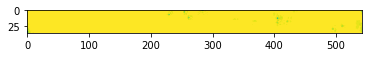

In [11]:
plt.imshow(img)

In [15]:
borders

[(0, 86), (76, 110), (100, 158), (148, 190), (188, 730)]

In [13]:
y_true_str

'меня.'

In [14]:
y_pred_str

'м^^^^^^^^^е^^нн^^^^я^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^'

In [19]:
!cp symb_db3000.hdf5 drive/MyDrive/'Colab Notebooks'/'CTR advanced'/align_model/symb_db3000.hdf5